# Plot Supp Figures

CC plots for random timeseries

For Sawi et al., 2021

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Define helper functions (move later)

In [3]:


def dateToEventID(cat):
    
    evID = []
    
    for i, dt in enumerate(cat.datetime):
        
        a = str(dt)    
        b = a.replace('-','').replace(':','').replace(' ','')[3:]
        
        
        evID.append(b)
        
    cat['event_ID'] = evID
    
    return cat




def getDailyTempDiff2(garciaDF_H,garciaDF_D,**plt_kwargs):

    tstart      =     plt_kwargs['tstartreal']
    tend        =     plt_kwargs['tendreal']

    garciaDF_H1 = garciaDF_H[garciaDF_H.datetime>=tstart]
    garciaDF_H1 = garciaDF_H1[garciaDF_H1.datetime<tend]

    garciaDF_D1 = garciaDF_D[garciaDF_D.datetime>=tstart]
    garciaDF_D1 = garciaDF_D1[garciaDF_D1.datetime<tend]


    temp_H = garciaDF_H1.temp_H.bfill()
    temp_H_a = np.array(temp_H)

    temp_H_a_r = temp_H_a.reshape(len(garciaDF_D1),24)
    mean_diff = []
    for i in range(len(temp_H_a_r[:,0])):
    #     plt.plot(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])
        mean_diff.append(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])


    mean_mean_diff = np.mean(mean_diff,axis=0)
    return mean_mean_diff



def catMergeFromH5(path_Cat,path_proj,outfile_name):
    '''
    Keep csv catalog events based on H5 used in SpecUFEx 
    
    '''
    
    ## read 'raw' catalog, the immutable one
    cat_raw = pd.read_csv(path_Cat)
    cat_raw['event_ID'] = [str(int(evv)) for evv in cat_raw['event_ID']]    
    
    
    ## load event IDs from H5
    MLout =  h5py.File(path_proj + outfile_name,'r')
    evID_kept = [evID.decode('utf-8') for evID in MLout['catalog/event_ID/'][:]]
    MLout.close()
    
    ## put H5 events into pandas dataframe
    df_kept = pd.DataFrame({'event_ID':evID_kept})

    ## merge based on event ID
    cat00 = pd.merge(cat_raw,df_kept,on='event_ID')
    
    ## if length of H5 events and merged catalog are equal, then success
    if len(evID_kept) == len(cat00):
        print(f'{len(cat00)} events kept, merge sucessful')
    else:
        print('check merge -- error may have occurred ')
    
    
    ## convert to datetime, set as index
    cat00['datetime'] = [pd.to_datetime(i) for i in cat00.datetime]
    cat00['datetime_index']= [pd.to_datetime(i) for i in cat00.datetime]
    cat00 = cat00.set_index('datetime_index')    


    return cat00
        
        
        

## Set paths

In [4]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathAuxData = '../data/external/GarciaEtAl_2019/processed/'

## Load auxiliary catalog

In [5]:
garciaDF_H = pd.read_csv(f'{pathAuxData}garciaDF_H.csv',index_col=0)
garciaDF_3H = pd.read_csv(f'{pathAuxData}garciaDF_3H.csv',index_col=0)
garciaDF_D = pd.read_csv(f'{pathAuxData}garciaDF_D.csv',index_col=0)


## when loading csv or text, sometimes need to reconvert this column to pandas datetime
garciaDF_H['datetime'] = [pd.to_datetime(ii) for ii in garciaDF_H.index]
garciaDF_3H['datetime'] = [pd.to_datetime(ii) for ii in garciaDF_3H.index]
garciaDF_D['datetime'] = [pd.to_datetime(ii) for ii in garciaDF_D.index]

garciaDF_H['datetime_index'] = [pd.to_datetime(ii) for ii in garciaDF_H.index]
garciaDF_3H['datetime_index'] = [pd.to_datetime(ii) for ii in garciaDF_3H.index]
garciaDF_D['datetime_index'] = [pd.to_datetime(ii) for ii in garciaDF_D.index]


garciaDF_H = garciaDF_H.set_index('datetime_index')
garciaDF_3H = garciaDF_3H.set_index('datetime_index')
garciaDF_D = garciaDF_D.set_index('datetime_index')



garciaDF_D.head(2)

,lake_D,temp_D,rain_D,gps24_D,gps34_D,gps36_D,gps37_D,datetime
datetime_index,,,,,,,,
2007-06-14,25.738000,3.526000,0.500000,0.000000,0.000000,0.000000,0.000000,2007-06-14
2007-06-15,26.140615,7.312125,0.054167,0.033048,0.016641,0.010967,0.012695,2007-06-15


## Define some important times in study period

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [7]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [8]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [9]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [10]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [11]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [12]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [13]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 5 - Reduce dimensionality, visualize PC plots by time, hour

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [14]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762943
3 0.277379352883
4 0.312981177456
5 0.343504167711
6 0.372574085719
7 0.39888876018
8 0.420887111884
9 0.439352595582
10 0.456394256085
11 0.472888430416
12 0.488607180078
13 0.503507958622
14 0.517448742225
15 0.530731442781
16 0.543704563552
17 0.556302610402
18 0.568397576411
19 0.580143466255
20 0.591289958302
21 0.602310132701
22 0.612569430501
23 0.621579994807
24 0.630823791421
25 0.639861667149
26 0.648682368973
27 0.65712762672
28 0.665349195573
29 0.673279880989
30 0.680638512209
31 0.68795659446
32 0.695079490233
33 0.701696587284
34 0.70900444564
35 0.715545876463
36 0.721810407888
37 0.72865931357
38 0.73444365793
39 0.740874780574
40 0.746835170138
41 0.752790934743
42 0.75846830021
43 0.76389126951
44 0.769334988168
45 0.774644230291
46 0.779831757858
47 0.785120337076
48 0.789636509406
49 0.794642155171
50 0.799112690401
51 0.803899532715
52 0.808436816883
53 0.812498322494
54 0.816773312324
55 0.820735870661
56 0.824882650205
57 0.8288

In [15]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.30% of variance explained by the first 67 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [16]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## Clustering using Kmeans, validating using silhouette score

In [17]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


### 10 most representative events

In [18]:
catRep = getTopFCat(cat00,topF=10) 

catRepN = getTopFCat(cat00N,topF=10)

In [20]:
len(catRepN)

40

# Cross correlation between topF events

https://docs.obspy.org/master/packages/autogen/obspy.signal.cross_correlation.correlate.html
    



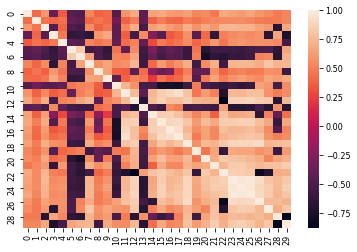

In [22]:
shift_cc = lenData


figureFunctions2.plotCCMatrix(catRep,shift_cc,dataH5_path,station,channel,fmin,fmax,fs)
plt.savefig(pathFig + 'S_CC_events.png')

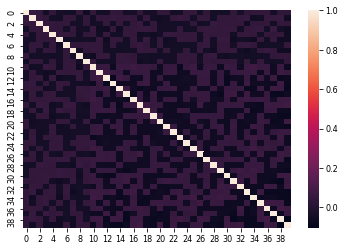

In [23]:
shift_ccN = lenDataN


figureFunctions2.plotCCMatrix(catRepN,shift_ccN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)
plt.savefig(pathFig + 'S_CC_Noise.png')

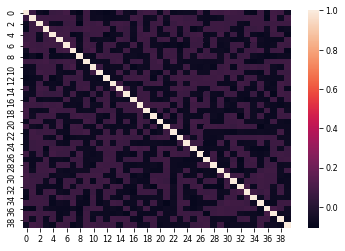

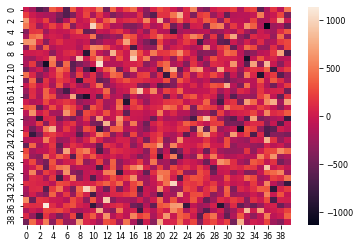

In [26]:
Nx = 40 #number of waveforms
Nsigma = 1 * np.ones(Nx) #array of std for gaussians for waveforms
mu = 0 #mean of gauss
wf_list = generate_noise(mu=mu, sigma=Nsigma, x=Nx, samples=lenData) #list of waveform arrays--- from Jonathon Sheppard
shift_cc = len(wf_list[0]) #max number of samples cross correlation can shift
plotCCMatrix_Synth(wf_list,shift_cc)
plt.savefig(pathFig + 'CC_RANDomnoise.png')

In [27]:
# -------------------------------------------- from Jonathon Sheppard


from random import gauss

def generate_noise(mu, sigma, x, samples):
    """
    Generate x number of random gaussian distributions.
    
    Parameters
    ----------
    mu: <int, float>
        Mean of the distribution
    sigma: <array, list>
        Standard deviation of the distribution
    x: <int>
        Number of arrays to create
    samples: <int>
        Number of points in the distribution
    """

    wf_list = np.zeros((x,samples))
    for i in range(x):
        wf_list[i] = [gauss(mu, sigma[i]) for j in range(samples)]
    npts = x
    
    return wf_list



def plotCCMatrix_Synth(wf_list,shift_cc):
###    shift_cc : #Number of samples to shift for cross correlation. The cross-correlation will consist of 2*shift+1 or 2*shift samples. The sample with zero shift will be in the middle.

    cc_mat = np.zeros([len(wf_list),len(wf_list)])
    lag_mat = np.zeros([len(wf_list),len(wf_list)])

    for i in range(len(wf_list)):
        for j in range(len(wf_list)):  
            
            wf_A = wf_list[i]
            wf_B = wf_list[j]
            
            
            cc = correlate(wf_A, wf_B, shift_cc)
            lag, max_cc = xcorr_max(cc)

            cc_mat[i,j] = max_cc
            lag_mat[i,j] = lag
        
    sns.heatmap(cc_mat)
#     plt.figure()
#     sns.heatmap(lag_mat)


In [19]:



## move to analysis
# clus_sel = [1,2,3]
# sel_state = [12,14,8]

# clus_selN = [1,2,3,4]
# sel_stateN = [6,3,5,4]

# leg = ['During/after flood','Before flood','PM']
# legN = ['During/after flood','Before flood','Rain?','PM']

# ## move to clustering
# mode = 'fingerprints'#'kernalPCA'#'fingerprints'#'PCA' 

# print(key,mode,Kopt, ' clusters')
